# Phase 1 - (Convolutional) Neural Networks

Please follow the notebook in order. Make sure to add code where indicated by `''' TODO '''` or `# YOUR CODE HERE`. Ensure your notebook is easy to follow. All written report answers should be provided in the notebook itself.

You may find [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) pytorch tutorial helpful.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

## 1. Loading & Visualizing Data

Please use MNIST for this Phase. MNIST is a digit classification dataset, with greyscale 28x28 images, and 10 classes (numbers 0-9). See [documentaion.](https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html) You can also see the MNIST_Tutorial.ipynb

Please complete loading the data.

Please also complete `show_imgs()`. Function should input the dataloader, and show random 10 images and their labels as title to plot. Make sure the 10 images are organized in a grid or format or with matplotlib axis.

In [2]:
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 104848577.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22637954.37it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25809513.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16422869.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



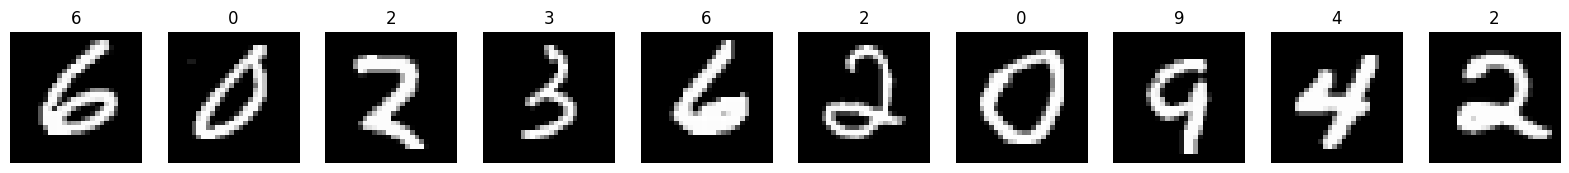

In [3]:
import torchvision
# Function should input the dataloader, and show random 10 images and their labels as title to plot

def show_imgs(imgs):
    # Create 10 subplots all in a row
    fig, ax = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        # get some random training images

        dataiter = iter(train_loader)
        images, labels = next(dataiter)
        npimg = torchvision.utils.make_grid(images[0]).numpy()
        ax[i].axis('off')
        ax[i].imshow(np.transpose(npimg, (1, 2, 0)))
        ax[i].set_title(labels[0].item())

show_imgs(train_loader)

## 2. Utility Functions

Please complete `train()` and `plot_learning_curves()` functions. `test_accuracy()` has already been provided to you.

In [4]:
def test_accuracy(model, test_loader, input_size, device):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            images = images.view(-1, input_size)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print('Accuracy: %d %%' % (100 * correct / total))
    return (100 * correct / total)


### 2.1 Train Function
Please refer to the train function in `MNIST_Classifier.ipynb` to complete this function. You will need to store the loss and accuracies per iteration to plot. Please print the loss, accuracy and time taken for training each epoch.

In [5]:
import time

# Do I need 2D array to store information on epoc and corresponding train/validation arrays?

def train(model, loss_fn, optimizer, train_loader, batch_size, num_epochs, device):
    # Train Accuracy and Loss Arrays
    acc_arr_train = []
    loss_arr_train = []

    # Validation Accuracy and Loss Arrays
    acc_arr_valid = []
    loss_arr_valid = []

    # Rolling Average Vaidation/Train Arrays for every 100 iterations
    loss_avg_valid = []
    loss_avg_train = []

    # Iterate through all Epochs
    for epoch in range(num_epochs):
      # Iterate through training dataset
      start_epoc_time = time.perf_counter()
      for i, data in enumerate(train_loader, 0):
        # Flatten images and load images/labels
        images, labels = data[0].cuda(), data[1].cuda()
        images = images.view(-1, input_size)
        # Zero collected gradients at each step
        optimizer.zero_grad()
        # Forward Propagate
        outputs = model(images)

        # Calculate train Loss
        loss = loss_function(outputs, labels)

        # Back propagate
        loss.backward()
        # Update weights
        optimizer.step()

        test_data = next(iter(test_loader)) # Access Corresponding Test Data

        test_im, test_label = test_data[0].cuda(), test_data[1].cuda()

        test_im = test_im.view(-1, input_size)
        test_outputs = model(test_im)
        valid_loss = loss_function(test_outputs, test_label)

        # Store Accuracy of current iteration
        # acc_arr_train.append(test_accuracy(model = net, test_loader = train_loader, input_size = input_size, device = None))

        # Store Loss of current iteration
        loss_arr_valid.append(valid_loss.item())
        loss_arr_train.append(loss.item())

        # Print statistics on every 100th iteration
        if (i+1) % 100 == 0:
          # Average the past 100 iterations and append that Loss value
          for j in range(len(loss_arr_valid) - 100 + 1):
            window_valid = loss_arr_valid[j:j + 100]
            window_train = loss_arr_train[j:j + 100]
            avg_valid = sum(window_valid) / 100
            avg_train = sum(window_train) / 100

          loss_avg_valid.append(avg_valid)
          loss_avg_train.append(avg_train) #TODO: Check to make sure it's only appended once per 100 iterations.

          #loss_arr_valid.append(valid_loss.item())
          #loss_arr_train.append(loss.item())
          print("""Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Val Loss: %.4f"""
                %(epoch+1, num_epochs, i+1,
                len(train_data) // batch_size, loss.item(), valid_loss.item())) # TODO: Do we want to print the avg_valid and avg_train then?


      time_epoc_stop = time.perf_counter() # Stop the timer

      # Average of train and validation accuracies:
      train_acc = test_accuracy(model, train_loader, input_size, None)
      test_acc = test_accuracy(model, test_loader, input_size, None)

      acc_arr_train.append(train_acc)
      acc_arr_valid.append(test_acc)

      # Print epoc, time taken for epoc, train accuracy, valid accuracy
      print("""Epoch [%d/%d], Time Taken: %.4f, Train Acc: %.4f, Valid Acc: %.4f"""
            % (epoch + 1, num_epochs, time_epoc_stop - start_epoc_time,
             train_acc, test_acc))
      print("--------------------------------------------------------------")

    return acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid

### 2.2 Plot Learning Curves Function
Plot the loss and accuracies from training

In [6]:
def plot_learning_curve(train_loss, valid_loss, title):
    plt.figure(0)
    plt.plot(range(0, len(train_loss*100), 100), train_loss, label = "Train Loss")
    plt.plot(range(0, len(valid_loss*100), 100), valid_loss, label = "Validation Loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

## 3) Define CNNs

A 1-Layer Architecture is already defined for you (`Net`) as a reference. Please complete the definitions of the 2-Layer CNN (`Net2`), 5-Layer CNN (`Net5`). The network architecture definitions are provided to you. You must calculate some dimensions yourself.

**NOTE:** For now, please use ReLU activation. You will experiment with other activations in Section 5.

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

### 3.1) 2-Layer CNN
Complete `Net2` class.

 Network Architecture:
* ***Layer 1 (Input)***: Convolutional; input channel = 1, output channel = 20, kernel size = 3, step size = 1.
* ***Layer 2 (Output)***: Fully connected; input dimension = < you find out >, output dimension = < you find out >.

In [8]:
# Define 2-Layer Network
class Net2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

## 4) Train and Evaluate

### 4.1) Here, you must test your utility functions (`train()` and `plot_learning_curves()`)with the 1-Layer Model. Please at this stage ensure your utility functions are working correctly.

**NOTE**: You can repeatedly use this below code black in Section 5 to run experiments, while making changes to the hyperparameters as requested.

In [9]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.2982, Val Loss: 0.2507
Epoch [1/5], Step [200/1875], Train Loss: 0.2968, Val Loss: 0.2017
Epoch [1/5], Step [300/1875], Train Loss: 0.3722, Val Loss: 0.0821
Epoch [1/5], Step [400/1875], Train Loss: 0.5166, Val Loss: 0.0376
Epoch [1/5], Step [500/1875], Train Loss: 0.0801, Val Loss: 0.2409
Epoch [1/5], Step [600/1875], Train Loss: 0.3265, Val Loss: 0.0812
Epoch [1/5], Step [700/1875], Train Loss: 0.0704, Val Loss: 0.1380
Epoch [1/5], Step [800/1875], Train Loss: 0.1285, Val Loss: 0.1711
Epoch [1/5], Step [900/1875], Train Loss: 0.5469, Val Loss: 0.2125
Epoch [1/5], Step [1000/1875], Train Loss: 0.4755, Val Loss: 0.0969
Epoch [1/5], Step [1100/1875], Train Loss: 0.3360, Val Loss: 0.1304
Epoch [1/5], Step [1200/1875], Train Loss: 0.0518, Val Loss: 0.0752
Epoch [1/5], Step [1300/1875], Train Loss: 0.1798, Val Loss: 0.0619
Epoch [1/5], Step [1400/1875], Train Loss: 0.2725, Val Loss: 0.2337
Epoch [1/5], Step [1500/1875], Train Loss: 0.2469, Val Lo

95.7

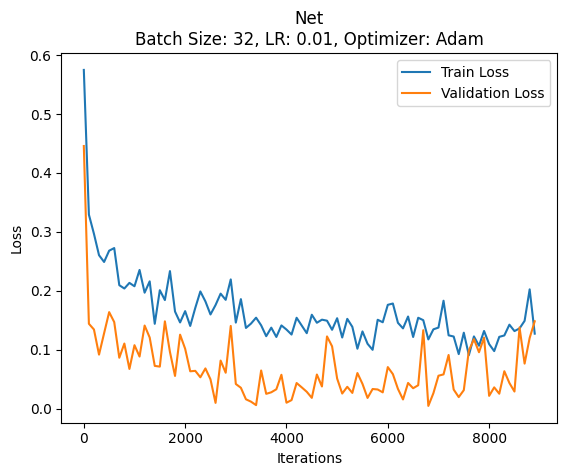

In [10]:
# Plot Learning Curves
plot_learning_curve(loss_avg_train, loss_avg_valid, "Net\nBatch Size: 32, LR: 0.01, Optimizer: Adam")

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

### 4.2) Please also train your 2-Layer network to ensure it is working properly.

In [11]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 10

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

#print(net)
# Train Model
Net2_acc_arr_train, Net2_acc_arr_valid, Net2_loss_avg_train, Net2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/10], Step [100/1875], Train Loss: 0.3633, Val Loss: 0.1295
Epoch [1/10], Step [200/1875], Train Loss: 0.0447, Val Loss: 0.1318
Epoch [1/10], Step [300/1875], Train Loss: 0.0503, Val Loss: 0.1362
Epoch [1/10], Step [400/1875], Train Loss: 0.2087, Val Loss: 0.0392
Epoch [1/10], Step [500/1875], Train Loss: 0.0976, Val Loss: 0.0815
Epoch [1/10], Step [600/1875], Train Loss: 0.0179, Val Loss: 0.0926
Epoch [1/10], Step [700/1875], Train Loss: 0.1749, Val Loss: 0.0955
Epoch [1/10], Step [800/1875], Train Loss: 0.1177, Val Loss: 0.0239
Epoch [1/10], Step [900/1875], Train Loss: 0.0355, Val Loss: 0.1574
Epoch [1/10], Step [1000/1875], Train Loss: 0.1373, Val Loss: 0.0771
Epoch [1/10], Step [1100/1875], Train Loss: 0.0661, Val Loss: 0.0132
Epoch [1/10], Step [1200/1875], Train Loss: 0.0070, Val Loss: 0.0466
Epoch [1/10], Step [1300/1875], Train Loss: 0.0486, Val Loss: 0.0207
Epoch [1/10], Step [1400/1875], Train Loss: 0.1129, Val Loss: 0.0137
Epoch [1/10], Step [1500/1875], Train Loss:

94.96

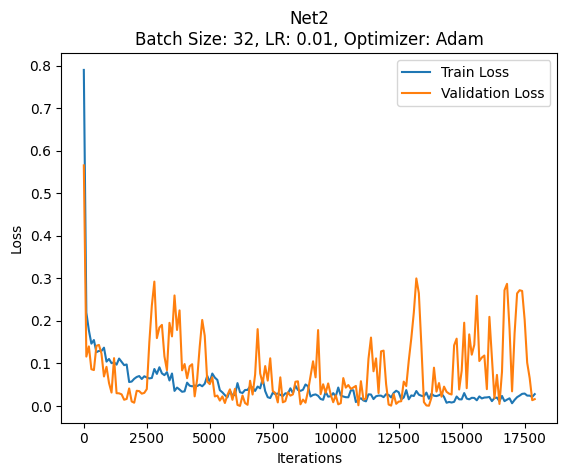

In [39]:
# Plot Learning Curves
plot_learning_curve(Net2_loss_avg_train, Net2_loss_avg_valid, "Net2\nBatch Size: 32, LR: 0.01, Optimizer: Adam")

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

## 5) Experiments and Reporting

In this section you will use your utility functioins and model definitons from before, and test for different scenarios. There are report questions you must answer for all sections below. Please use the loss, accuracy, and learning curves to help answer questions.

**NOTE:** In this section we will only change different parameters, so you can call most of your functions from previous sections. Any modifications needed in code asked by the questions in Section 5, please add them in the code sections indicated by `# YOUR CODE HERE`

### 5.1) Learning Curves

#### **Q 5.1) What is a Learning curve and why is it useful? You can refer to learning curves you have plotted in Section 4.**

---

A Learning curve measures the validation and training loss for each iteration. It is useful because it tells us whether the model is overfitting or underfitting.

### 5.2) Learning Rates

Please plot the curves for three separate training instances with learning rates of 2e-3, 3e-4, 5e-2. Use the 2-Layer CNN.

#### **Q 5.2) For each learning rate, explain if the model is underfitting, overfitting, or is training well. Explain the difference between high learning rates and low learning rates in terms of the optimization process.**

In [13]:
# Learning Rate 2e-3, "LR1"
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR1_acc_arr_train, LR1_acc_arr_valid, LR1_loss_avg_train, LR1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.3383, Val Loss: 0.1410
Epoch [1/5], Step [200/1875], Train Loss: 0.4145, Val Loss: 0.1063
Epoch [1/5], Step [300/1875], Train Loss: 0.0696, Val Loss: 0.2009
Epoch [1/5], Step [400/1875], Train Loss: 0.1838, Val Loss: 0.0646
Epoch [1/5], Step [500/1875], Train Loss: 0.1184, Val Loss: 0.0479
Epoch [1/5], Step [600/1875], Train Loss: 0.2764, Val Loss: 0.0846
Epoch [1/5], Step [700/1875], Train Loss: 0.0494, Val Loss: 0.0939
Epoch [1/5], Step [800/1875], Train Loss: 0.0696, Val Loss: 0.1332
Epoch [1/5], Step [900/1875], Train Loss: 0.1173, Val Loss: 0.1098
Epoch [1/5], Step [1000/1875], Train Loss: 0.0952, Val Loss: 0.1070
Epoch [1/5], Step [1100/1875], Train Loss: 0.1405, Val Loss: 0.1332
Epoch [1/5], Step [1200/1875], Train Loss: 0.1120, Val Loss: 0.2029
Epoch [1/5], Step [1300/1875], Train Loss: 0.1504, Val Loss: 0.1075
Epoch [1/5], Step [1400/1875], Train Loss: 0.2296, Val Loss: 0.1754
Epoch [1/5], Step [1500/1875], Train Loss: 0.0559, Val Lo

In [14]:
# Learning Rate 3e-4, "LR2"
# Define Parameters
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR2_acc_arr_train, LR2_acc_arr_valid, LR2_loss_avg_train, LR2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.5869, Val Loss: 0.5189
Epoch [1/5], Step [200/1875], Train Loss: 0.2196, Val Loss: 0.2126
Epoch [1/5], Step [300/1875], Train Loss: 0.3236, Val Loss: 0.2135
Epoch [1/5], Step [400/1875], Train Loss: 0.4939, Val Loss: 0.1658
Epoch [1/5], Step [500/1875], Train Loss: 0.3837, Val Loss: 0.2172
Epoch [1/5], Step [600/1875], Train Loss: 0.3741, Val Loss: 0.1840
Epoch [1/5], Step [700/1875], Train Loss: 0.2966, Val Loss: 0.1222
Epoch [1/5], Step [800/1875], Train Loss: 0.2934, Val Loss: 0.1504
Epoch [1/5], Step [900/1875], Train Loss: 0.1764, Val Loss: 0.1213
Epoch [1/5], Step [1000/1875], Train Loss: 0.0911, Val Loss: 0.2058
Epoch [1/5], Step [1100/1875], Train Loss: 0.1675, Val Loss: 0.2166
Epoch [1/5], Step [1200/1875], Train Loss: 0.2961, Val Loss: 0.1920
Epoch [1/5], Step [1300/1875], Train Loss: 0.2460, Val Loss: 0.2420
Epoch [1/5], Step [1400/1875], Train Loss: 0.1482, Val Loss: 0.1472
Epoch [1/5], Step [1500/1875], Train Loss: 0.1302, Val Lo

In [15]:
# Learning Rate 5e-2, "LR3"
# Define Parameters
input_size = 784
num_classes = 10
lr = 5e-2
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR3_acc_arr_train, LR3_acc_arr_valid, LR3_loss_avg_train, LR3_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.5437, Val Loss: 0.4056
Epoch [1/5], Step [200/1875], Train Loss: 0.3215, Val Loss: 0.3426
Epoch [1/5], Step [300/1875], Train Loss: 0.7940, Val Loss: 0.1162
Epoch [1/5], Step [400/1875], Train Loss: 0.5815, Val Loss: 0.2040
Epoch [1/5], Step [500/1875], Train Loss: 0.6376, Val Loss: 0.3108
Epoch [1/5], Step [600/1875], Train Loss: 0.3079, Val Loss: 0.2986
Epoch [1/5], Step [700/1875], Train Loss: 0.5084, Val Loss: 0.3448
Epoch [1/5], Step [800/1875], Train Loss: 0.4703, Val Loss: 0.1539
Epoch [1/5], Step [900/1875], Train Loss: 0.3478, Val Loss: 0.2922
Epoch [1/5], Step [1000/1875], Train Loss: 0.5516, Val Loss: 0.2787
Epoch [1/5], Step [1100/1875], Train Loss: 0.1253, Val Loss: 0.1840
Epoch [1/5], Step [1200/1875], Train Loss: 0.5239, Val Loss: 0.2104
Epoch [1/5], Step [1300/1875], Train Loss: 0.6813, Val Loss: 0.3418
Epoch [1/5], Step [1400/1875], Train Loss: 0.4871, Val Loss: 0.4159
Epoch [1/5], Step [1500/1875], Train Loss: 0.4049, Val Lo

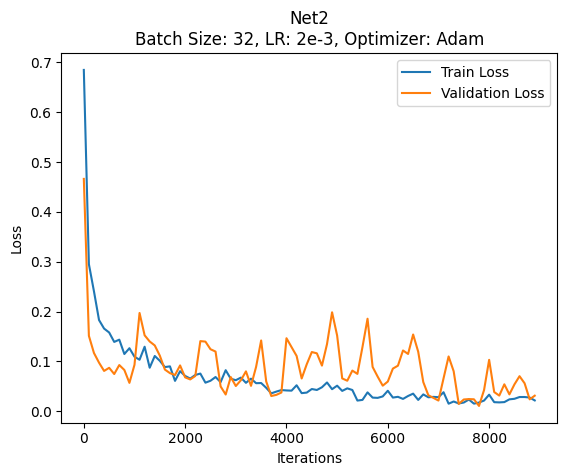

In [40]:
# Plot the curves:

# TODO: Label the plot titles
plot_learning_curve(LR1_loss_avg_train, LR1_loss_avg_valid, "Net2\nBatch Size: 32, LR: 2e-3, Optimizer: Adam")

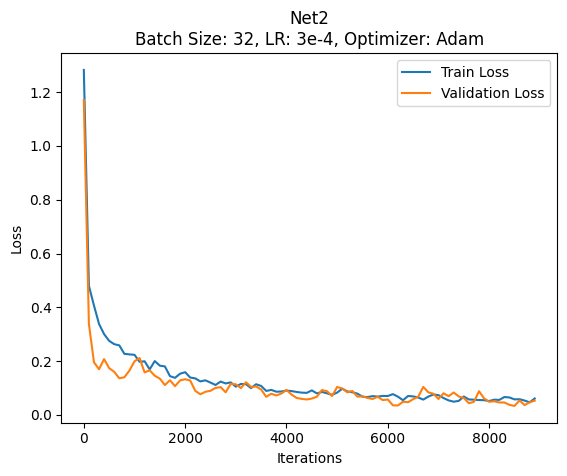

In [41]:
plot_learning_curve(LR2_loss_avg_train, LR2_loss_avg_valid, "Net2\nBatch Size: 32, LR: 3e-4, Optimizer: Adam")

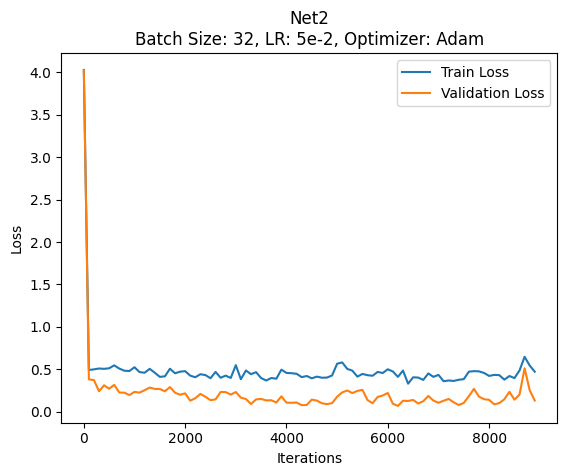

In [42]:
plot_learning_curve(LR3_loss_avg_train, LR3_loss_avg_valid, "Net2\nBatch Size: 32, LR: 5e-2, Optimizer: Adam")

---

### 5.3) Optimizer
The optimizer we have used before is Adam. Change the optimizer to use stochastic gradient descent (SGD), and SGD with momentum. Use 2-Layer CNN.

#### **Q 5.3) Explain the differences in Adam and both SGD optimizations. Compare the results of each optimizer based on the learning curves.**

Adam uses a changing learning rate throughout optimization while the SGD implementations both use a fixed learning rate. SGD with momentum takes into account previous gradient information for each step in an attempt to not get stuck in local minimum. Adam usually converges faster due to its changing learning rate.

In [20]:
# Optimizer SGD
# Learning Rate 0.002
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Train Model
SGD_acc_arr_train, SGD_acc_arr_valid, SGD_loss_avg_train, SGD_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 1.5587, Val Loss: 1.4181
Epoch [1/5], Step [200/1875], Train Loss: 1.0258, Val Loss: 0.9401
Epoch [1/5], Step [300/1875], Train Loss: 0.7548, Val Loss: 0.7004
Epoch [1/5], Step [400/1875], Train Loss: 0.5507, Val Loss: 0.5644
Epoch [1/5], Step [500/1875], Train Loss: 0.5418, Val Loss: 0.4652
Epoch [1/5], Step [600/1875], Train Loss: 0.4911, Val Loss: 0.4178
Epoch [1/5], Step [700/1875], Train Loss: 0.5424, Val Loss: 0.3624
Epoch [1/5], Step [800/1875], Train Loss: 0.5174, Val Loss: 0.3441
Epoch [1/5], Step [900/1875], Train Loss: 0.3840, Val Loss: 0.3046
Epoch [1/5], Step [1000/1875], Train Loss: 0.2687, Val Loss: 0.2976
Epoch [1/5], Step [1100/1875], Train Loss: 0.6368, Val Loss: 0.2805
Epoch [1/5], Step [1200/1875], Train Loss: 0.2713, Val Loss: 0.2677
Epoch [1/5], Step [1300/1875], Train Loss: 0.5461, Val Loss: 0.2658
Epoch [1/5], Step [1400/1875], Train Loss: 0.3169, Val Loss: 0.2547
Epoch [1/5], Step [1500/1875], Train Loss: 0.1970, Val Lo

In [21]:
# Optimizer SGD (Momentum = 0.9), SGDM
# Learning Rate 0.002
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
SGDM_acc_arr_train, SGDM_acc_arr_valid, SGDM_loss_avg_train, SGDM_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.8148, Val Loss: 0.4195
Epoch [1/5], Step [200/1875], Train Loss: 0.2639, Val Loss: 0.2321
Epoch [1/5], Step [300/1875], Train Loss: 0.4634, Val Loss: 0.2301
Epoch [1/5], Step [400/1875], Train Loss: 0.7233, Val Loss: 0.2575
Epoch [1/5], Step [500/1875], Train Loss: 0.1636, Val Loss: 0.2254
Epoch [1/5], Step [600/1875], Train Loss: 0.3190, Val Loss: 0.2770
Epoch [1/5], Step [700/1875], Train Loss: 0.1776, Val Loss: 0.2304
Epoch [1/5], Step [800/1875], Train Loss: 0.1733, Val Loss: 0.2363
Epoch [1/5], Step [900/1875], Train Loss: 0.2157, Val Loss: 0.1782
Epoch [1/5], Step [1000/1875], Train Loss: 0.2051, Val Loss: 0.1768
Epoch [1/5], Step [1100/1875], Train Loss: 0.1680, Val Loss: 0.2319
Epoch [1/5], Step [1200/1875], Train Loss: 0.2621, Val Loss: 0.1988
Epoch [1/5], Step [1300/1875], Train Loss: 0.2829, Val Loss: 0.2186
Epoch [1/5], Step [1400/1875], Train Loss: 0.3060, Val Loss: 0.1789
Epoch [1/5], Step [1500/1875], Train Loss: 0.3423, Val Lo

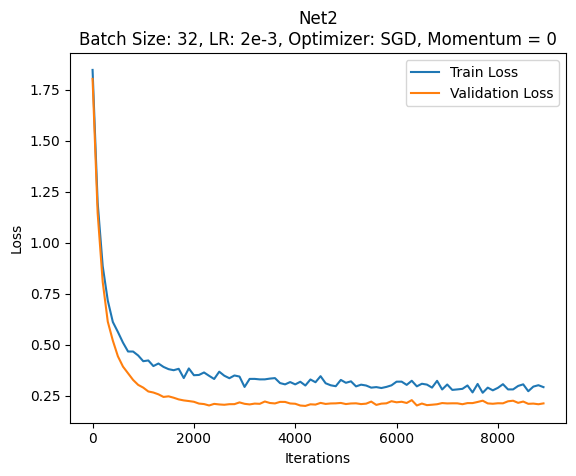

In [43]:
plot_learning_curve(SGD_loss_avg_train, SGD_loss_avg_valid, "Net2\nBatch Size: 32, LR: 2e-3, Optimizer: SGD, Momentum = 0")

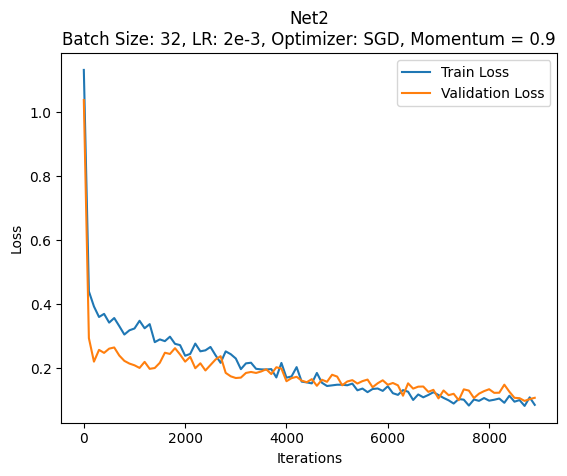

In [44]:
plot_learning_curve(SGDM_loss_avg_train, SGDM_loss_avg_valid, "Net2\nBatch Size: 32, LR: 2e-3, Optimizer: SGD, Momentum = 0.9")

---

### 5.4) Initializing Weights

Initialize the weights to all zeros, all ones and all randomly initialized with a normal distribution. Use 2-Layer CNN.

#### **Q 5.4) How is the training process affected when we initialize our network weights differently? Based on what you observe, give a recommendation as to how weights should be initialized. Explain your reasoning.**

Doing random initialization is best because set values have the problem of having similar gradients initially which can lead to the model getting stuck in a local minimum.

In [24]:
# Define 2-Layer Network
class Net2_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_0, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.conv1.weight.data.fill_(0)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        self.fc2.weight.data.fill_(0)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [25]:
# Define 2-Layer Network
class Net2_1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.conv1.weight.data.fill_(1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        self.fc2.weight.data.fill_(1)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [26]:
# Define 2-Layer Network
class Net2_rand(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_rand, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight, gain=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1)


    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [27]:
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_0(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN0_acc_arr_train, CNN0_acc_arr_valid, CNN0_loss_avg_train, CNN0_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.7561, Val Loss: 0.3125
Epoch [1/5], Step [200/1875], Train Loss: 0.2532, Val Loss: 0.2919
Epoch [1/5], Step [300/1875], Train Loss: 0.5740, Val Loss: 0.1921
Epoch [1/5], Step [400/1875], Train Loss: 0.2367, Val Loss: 0.1911
Epoch [1/5], Step [500/1875], Train Loss: 0.5980, Val Loss: 0.1171
Epoch [1/5], Step [600/1875], Train Loss: 0.2737, Val Loss: 0.1920
Epoch [1/5], Step [700/1875], Train Loss: 0.1913, Val Loss: 0.2107
Epoch [1/5], Step [800/1875], Train Loss: 0.3826, Val Loss: 0.2441
Epoch [1/5], Step [900/1875], Train Loss: 0.4415, Val Loss: 0.2173
Epoch [1/5], Step [1000/1875], Train Loss: 0.4008, Val Loss: 0.2268
Epoch [1/5], Step [1100/1875], Train Loss: 0.3188, Val Loss: 0.1708
Epoch [1/5], Step [1200/1875], Train Loss: 0.3280, Val Loss: 0.1352
Epoch [1/5], Step [1300/1875], Train Loss: 0.1795, Val Loss: 0.1592
Epoch [1/5], Step [1400/1875], Train Loss: 0.2406, Val Loss: 0.1206
Epoch [1/5], Step [1500/1875], Train Loss: 0.0586, Val Lo

In [28]:
# Initialize all weights to 1
# Learning Rate 5e-2
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_1(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN1_acc_arr_train, CNN1_acc_arr_valid, CNN1_loss_avg_train, CNN1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.2700, Val Loss: 1.4442
Epoch [1/5], Step [200/1875], Train Loss: 6.1931, Val Loss: 3.6151
Epoch [1/5], Step [300/1875], Train Loss: 4.1702, Val Loss: 1.8758
Epoch [1/5], Step [400/1875], Train Loss: 3.9217, Val Loss: 1.4263
Epoch [1/5], Step [500/1875], Train Loss: 2.0854, Val Loss: 0.7944
Epoch [1/5], Step [600/1875], Train Loss: 0.2644, Val Loss: 1.0916
Epoch [1/5], Step [700/1875], Train Loss: 1.1615, Val Loss: 0.7122
Epoch [1/5], Step [800/1875], Train Loss: 0.1483, Val Loss: 0.4776
Epoch [1/5], Step [900/1875], Train Loss: 0.3342, Val Loss: 0.3419
Epoch [1/5], Step [1000/1875], Train Loss: 0.0966, Val Loss: 0.4329
Epoch [1/5], Step [1100/1875], Train Loss: 0.6033, Val Loss: 0.3203
Epoch [1/5], Step [1200/1875], Train Loss: 0.1468, Val Loss: 0.3086
Epoch [1/5], Step [1300/1875], Train Loss: 1.1386, Val Loss: 0.3364
Epoch [1/5], Step [1400/1875], Train Loss: 0.4498, Val Loss: 0.3362
Epoch [1/5], Step [1500/1875], Train Loss: 0.1299, Val Lo

In [29]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_rand(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNNrand_acc_arr_train, CNNrand_acc_arr_valid, CNNrand_loss_avg_train, CNNrand_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.4350, Val Loss: 0.1808
Epoch [1/5], Step [200/1875], Train Loss: 0.6552, Val Loss: 0.1585
Epoch [1/5], Step [300/1875], Train Loss: 0.4537, Val Loss: 0.1966
Epoch [1/5], Step [400/1875], Train Loss: 0.2362, Val Loss: 0.0550
Epoch [1/5], Step [500/1875], Train Loss: 0.3253, Val Loss: 0.0483
Epoch [1/5], Step [600/1875], Train Loss: 0.0958, Val Loss: 0.0534
Epoch [1/5], Step [700/1875], Train Loss: 0.1935, Val Loss: 0.0793
Epoch [1/5], Step [800/1875], Train Loss: 0.0701, Val Loss: 0.1988
Epoch [1/5], Step [900/1875], Train Loss: 0.0417, Val Loss: 0.1730
Epoch [1/5], Step [1000/1875], Train Loss: 0.1701, Val Loss: 0.0822
Epoch [1/5], Step [1100/1875], Train Loss: 0.0580, Val Loss: 0.0818
Epoch [1/5], Step [1200/1875], Train Loss: 0.0560, Val Loss: 0.0277
Epoch [1/5], Step [1300/1875], Train Loss: 0.0249, Val Loss: 0.0195
Epoch [1/5], Step [1400/1875], Train Loss: 0.0426, Val Loss: 0.0561
Epoch [1/5], Step [1500/1875], Train Loss: 0.0146, Val Lo

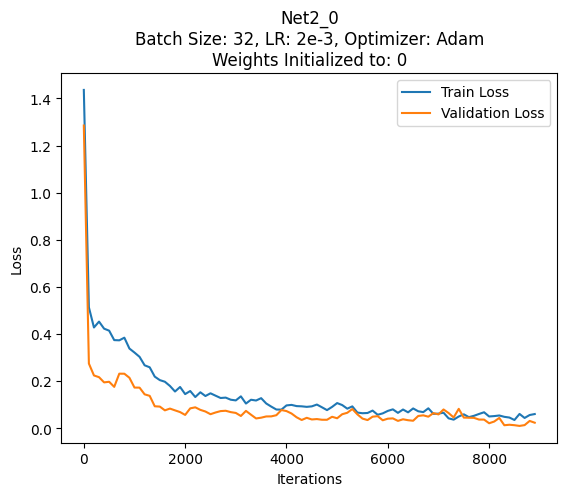

In [34]:
plot_learning_curve(CNN0_loss_avg_train, CNN0_loss_avg_valid, "Net2_0\nBatch Size: 32, LR: 2e-3, Optimizer: Adam\nWeights Initialized to: 0")

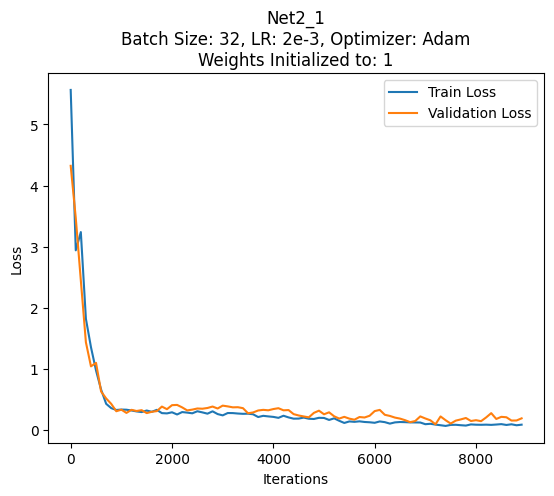

In [36]:
plot_learning_curve(CNN1_loss_avg_train, CNN1_loss_avg_valid, "Net2_1\nBatch Size: 32, LR: 2e-3, Optimizer: Adam\nWeights Initialized to: 1")

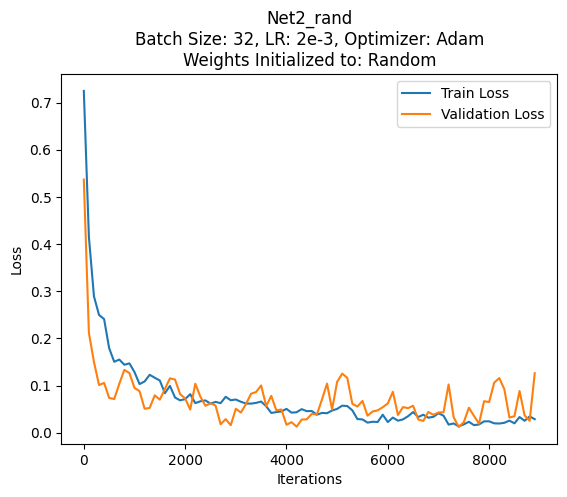

In [35]:
plot_learning_curve(CNNrand_loss_avg_train, CNNrand_loss_avg_valid, "Net2_rand\nBatch Size: 32, LR: 2e-3, Optimizer: Adam\nWeights Initialized to: Random")

---

### 5.5) Activation Function

Please change the relu function in the example code to a tanh function. Use 2-Layer CNN.

#### **Q 5.5) How does changing the activation function to tanh affect the performance. Is it better or worse? Explain why.**

Changing the function to tanh decreased the performance because it causes slower convergence due to having lower value gradients for positive values which is what we have in the image input.

In [37]:
# Define 2-Layer Network
class Net2_tanh(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_tanh, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.tanh(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [38]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_tanh(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNNtanh_acc_arr_train, CNNtanh_acc_arr_valid, CNNtanh_loss_avg_train, CNNtanh_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.2426, Val Loss: 0.3112
Epoch [1/5], Step [200/1875], Train Loss: 0.7936, Val Loss: 0.2790
Epoch [1/5], Step [300/1875], Train Loss: 0.4081, Val Loss: 0.1358
Epoch [1/5], Step [400/1875], Train Loss: 0.7714, Val Loss: 0.2473
Epoch [1/5], Step [500/1875], Train Loss: 0.1738, Val Loss: 0.2462
Epoch [1/5], Step [600/1875], Train Loss: 0.9638, Val Loss: 0.2446
Epoch [1/5], Step [700/1875], Train Loss: 0.5357, Val Loss: 0.2326
Epoch [1/5], Step [800/1875], Train Loss: 0.2926, Val Loss: 0.2137
Epoch [1/5], Step [900/1875], Train Loss: 0.5781, Val Loss: 0.2306
Epoch [1/5], Step [1000/1875], Train Loss: 0.1909, Val Loss: 0.3205
Epoch [1/5], Step [1100/1875], Train Loss: 0.3107, Val Loss: 0.2456
Epoch [1/5], Step [1200/1875], Train Loss: 0.2112, Val Loss: 0.2705
Epoch [1/5], Step [1300/1875], Train Loss: 0.1143, Val Loss: 0.3137
Epoch [1/5], Step [1400/1875], Train Loss: 0.7562, Val Loss: 0.2327
Epoch [1/5], Step [1500/1875], Train Loss: 0.2574, Val Lo

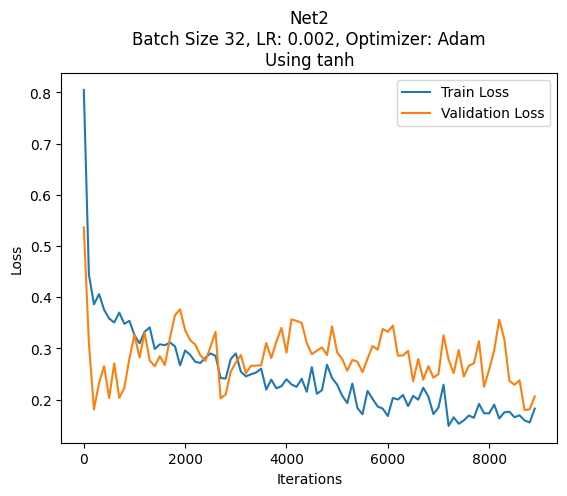

In [46]:
plot_learning_curve(CNNtanh_loss_avg_train, CNNtanh_loss_avg_valid, "Net2\nBatch Size 32, LR: 0.002, Optimizer: Adam\nUsing tanh")

---

### 5.6) Batch Size

Please use batch size of 128, 256, 512. Use 2-Layer CNN.

#### **Q 5.6) How does changing batch size affect the training process?**

Having larger batch sizes can lead to better generalization as the gradients are updated based on a larger amount of data which prevents outliers from having a large impact. It will take longer however since more memory needs to be allocated on the GPU for a larger batch to be processed. It could require more epochs to be done to converge as the gradients are updated less often so less steps are taken in the direction of the gradient which causes slower convergence.

In [47]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [48]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_1_acc_arr_train, CNN_1_acc_arr_valid, CNN_1_loss_avg_train, CNN_1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/468], Train Loss: 0.3700, Val Loss: 0.1621
Epoch [1/5], Step [200/468], Train Loss: 0.2100, Val Loss: 0.0924
Epoch [1/5], Step [300/468], Train Loss: 0.1269, Val Loss: 0.0730
Epoch [1/5], Step [400/468], Train Loss: 0.0850, Val Loss: 0.0481
Epoch [1/5], Time Taken: 14.0364, Train Acc: 97.5033, Valid Acc: 97.2000
--------------------------------------------------------------
Epoch [2/5], Step [100/468], Train Loss: 0.1269, Val Loss: 0.0487
Epoch [2/5], Step [200/468], Train Loss: 0.0430, Val Loss: 0.0638
Epoch [2/5], Step [300/468], Train Loss: 0.0576, Val Loss: 0.0585
Epoch [2/5], Step [400/468], Train Loss: 0.0403, Val Loss: 0.0362
Epoch [2/5], Time Taken: 14.7745, Train Acc: 98.4167, Valid Acc: 97.7100
--------------------------------------------------------------
Epoch [3/5], Step [100/468], Train Loss: 0.0209, Val Loss: 0.0527
Epoch [3/5], Step [200/468], Train Loss: 0.0486, Val Loss: 0.0406
Epoch [3/5], Step [300/468], Train Loss: 0.1082, Val Loss: 0.0441
Ep

In [49]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [50]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_2_acc_arr_train, CNN_2_acc_arr_valid, CNN_2_loss_avg_train, CNN_2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/234], Train Loss: 0.3036, Val Loss: 0.1412
Epoch [1/5], Step [200/234], Train Loss: 0.1848, Val Loss: 0.0939
Epoch [1/5], Time Taken: 14.1376, Train Acc: 96.7067, Valid Acc: 96.4400
--------------------------------------------------------------
Epoch [2/5], Step [100/234], Train Loss: 0.0804, Val Loss: 0.0672
Epoch [2/5], Step [200/234], Train Loss: 0.1229, Val Loss: 0.0497
Epoch [2/5], Time Taken: 13.4305, Train Acc: 98.1150, Valid Acc: 97.5800
--------------------------------------------------------------
Epoch [3/5], Step [100/234], Train Loss: 0.0859, Val Loss: 0.0566
Epoch [3/5], Step [200/234], Train Loss: 0.0322, Val Loss: 0.0313
Epoch [3/5], Time Taken: 13.4387, Train Acc: 98.6917, Valid Acc: 98.0200
--------------------------------------------------------------
Epoch [4/5], Step [100/234], Train Loss: 0.0412, Val Loss: 0.0498
Epoch [4/5], Step [200/234], Train Loss: 0.0689, Val Loss: 0.0389
Epoch [4/5], Time Taken: 13.4259, Train Acc: 98.9700, Valid Acc:

In [51]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [52]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_3_acc_arr_train, CNN_3_acc_arr_valid, CNN_3_loss_avg_train, CNN_3_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/117], Train Loss: 0.2053, Val Loss: 0.1880
Epoch [1/5], Time Taken: 13.4376, Train Acc: 95.0567, Valid Acc: 94.8000
--------------------------------------------------------------
Epoch [2/5], Step [100/117], Train Loss: 0.1650, Val Loss: 0.1167
Epoch [2/5], Time Taken: 13.2391, Train Acc: 97.0933, Valid Acc: 96.8000
--------------------------------------------------------------
Epoch [3/5], Step [100/117], Train Loss: 0.0780, Val Loss: 0.0961
Epoch [3/5], Time Taken: 13.6450, Train Acc: 97.7850, Valid Acc: 97.2700
--------------------------------------------------------------
Epoch [4/5], Step [100/117], Train Loss: 0.0764, Val Loss: 0.0741
Epoch [4/5], Time Taken: 13.3346, Train Acc: 98.3300, Valid Acc: 97.4700
--------------------------------------------------------------
Epoch [5/5], Step [100/117], Train Loss: 0.0620, Val Loss: 0.0676
Epoch [5/5], Time Taken: 13.6113, Train Acc: 98.4667, Valid Acc: 97.6300
-----------------------------------------------------

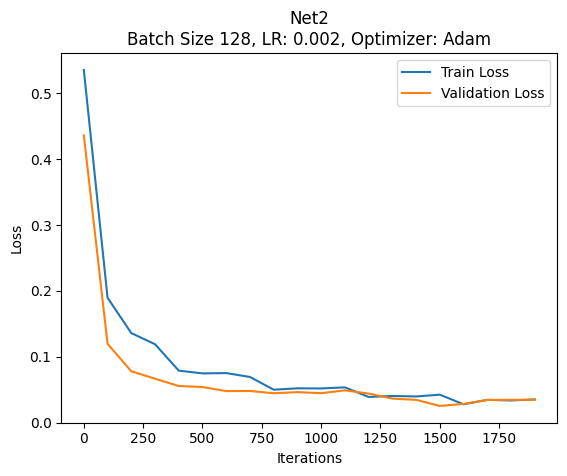

In [53]:
plot_learning_curve(CNN_1_loss_avg_train, CNN_1_loss_avg_valid, "Net2\nBatch Size 128, LR: 0.002, Optimizer: Adam")

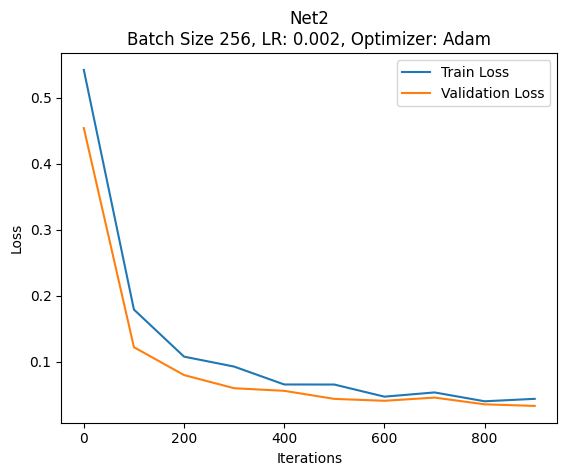

In [54]:
plot_learning_curve(CNN_2_loss_avg_train, CNN_2_loss_avg_valid, "Net2\nBatch Size 256, LR: 0.002, Optimizer: Adam")

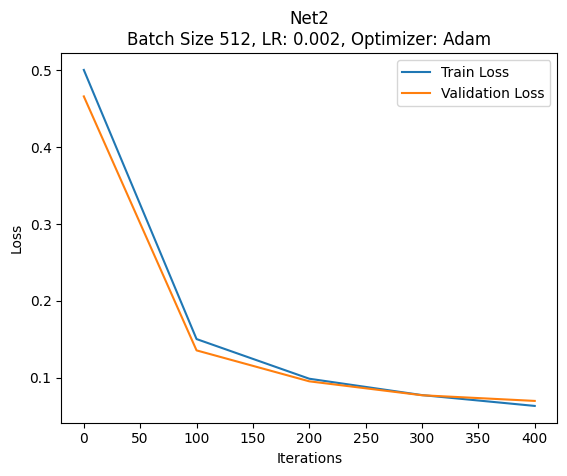

In [55]:
plot_learning_curve(CNN_3_loss_avg_train, CNN_3_loss_avg_valid, "Net2\nBatch Size 512, LR: 0.002, Optimizer: Adam")

---

### 5.7) Different Network Architectures

Please complete the `Net5` and `FCN` definitions. The archtiectures are defined below.

Train `Net`, `Net2`, `Net5`, and `FCN` using batch size of 64, the best learning rate from Section 5.1, and the best optimizer froom Section 5.5

#### **Q 5.7.1) Explain which model is better and why. Use your learning curves as well as what you know about model capacity to explain your reasoning.**

#### **Q 5.7.2) Which model converges to a minimum faster? Why? What hyperparameters would you tune in order to get a model to converge faster?**

#### **Q 5.7.3) Explain the purpose of the pooling layer**

#### **Q 5.7.4)  Is it possible for a model to have a smaller final loss, even if it has worse test accuracy.**

#### **Q 5.7.5) Explain the difference between the CNN models and FCN.**

5.7.1 The Net model is better because it a shallower network. The Net5 model overfits because it is a deeper network, which leads to a lower accuracy compared to the Net. The same logic can be applied for the Net2, which is close in accuracy to the Net. The Net has a higher accuracy than the FCN most likely because FCNs are best when used for pixel-level predictions and highly detailed spatial localization. CNNs shine in single output predictions in relation to the entire image.

5.7.2 Net5 converges to a minimum faster. This makes sense due to its higher complexity and thus can be seen overfitting the data. As a result, it converges to the minimum much quicker. To have a model converge faster, we would increase the learning rate, and lowering the batch size so that less steps are taken per epoch.

5.7.3 : The purpose of the pooling layer is to reduce the dimensions of the input volume, decreasing the amount of parameters in the neural network, which ultimately lends way to a reduction of overfitting

5.7.4: Yes, it's possible for a model to have a smaller final loss with a worse test accuracy. This may occur if the model is overfitted, and struggles to generalize. The finals loss is lower as it indicates a good fit.

5.7.5 The CNN model uses layers and is better fitted for single output prediction tasks that take into account the entire image. The FCN model identifies the objects in the individual pixels of an image, and thus is better fitted when used for pixel-level predicitions and more highly detailed spatial localization tasks.



In [56]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [57]:
# Net
# Learning Rate 2e-3, "LR1"
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
Net_64_acc_arr_train, Net_64_acc_arr_valid, Net_64_loss_avg_train, Net_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.3861, Val Loss: 0.2461
Epoch [1/5], Step [200/937], Train Loss: 0.3454, Val Loss: 0.2063
Epoch [1/5], Step [300/937], Train Loss: 0.2640, Val Loss: 0.1354
Epoch [1/5], Step [400/937], Train Loss: 0.2398, Val Loss: 0.1028
Epoch [1/5], Step [500/937], Train Loss: 0.1002, Val Loss: 0.0851
Epoch [1/5], Step [600/937], Train Loss: 0.0584, Val Loss: 0.0824
Epoch [1/5], Step [700/937], Train Loss: 0.1971, Val Loss: 0.0459
Epoch [1/5], Step [800/937], Train Loss: 0.0965, Val Loss: 0.0498
Epoch [1/5], Step [900/937], Train Loss: 0.0748, Val Loss: 0.0530
Epoch [1/5], Time Taken: 18.9519, Train Acc: 97.0600, Valid Acc: 96.5200
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.0925, Val Loss: 0.0245
Epoch [2/5], Step [200/937], Train Loss: 0.0692, Val Loss: 0.0242
Epoch [2/5], Step [300/937], Train Loss: 0.0332, Val Loss: 0.0234
Epoch [2/5], Step [400/937], Train Loss: 0.0178, Val Loss: 0.0386
Epoch 

In [58]:
# Net2
# Learning Rate 2e-3, "LR1"
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
Net2_64_acc_arr_train, Net2_64_acc_arr_valid, Net2_64_loss_avg_train, Net2_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.3294, Val Loss: 0.2134
Epoch [1/5], Step [200/937], Train Loss: 0.1207, Val Loss: 0.1473
Epoch [1/5], Step [300/937], Train Loss: 0.0909, Val Loss: 0.1187
Epoch [1/5], Step [400/937], Train Loss: 0.0694, Val Loss: 0.1178
Epoch [1/5], Step [500/937], Train Loss: 0.1319, Val Loss: 0.0517
Epoch [1/5], Step [600/937], Train Loss: 0.2260, Val Loss: 0.0941
Epoch [1/5], Step [700/937], Train Loss: 0.1730, Val Loss: 0.1015
Epoch [1/5], Step [800/937], Train Loss: 0.0523, Val Loss: 0.0659
Epoch [1/5], Step [900/937], Train Loss: 0.0383, Val Loss: 0.0361
Epoch [1/5], Time Taken: 16.2055, Train Acc: 97.9433, Valid Acc: 97.5000
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.0413, Val Loss: 0.0638
Epoch [2/5], Step [200/937], Train Loss: 0.1065, Val Loss: 0.0681
Epoch [2/5], Step [300/937], Train Loss: 0.0915, Val Loss: 0.1163
Epoch [2/5], Step [400/937], Train Loss: 0.0678, Val Loss: 0.0872
Epoch 

In [61]:
# Net5
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net5(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
Net5_64_acc_arr_train, Net5_64_acc_arr_valid, Net5_64_loss_avg_train, Net5_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.1455, Val Loss: 0.1555
Epoch [1/5], Step [200/937], Train Loss: 0.1857, Val Loss: 0.0587
Epoch [1/5], Step [300/937], Train Loss: 0.1367, Val Loss: 0.0692
Epoch [1/5], Step [400/937], Train Loss: 0.0408, Val Loss: 0.0621
Epoch [1/5], Step [500/937], Train Loss: 0.0499, Val Loss: 0.0187
Epoch [1/5], Step [600/937], Train Loss: 0.0302, Val Loss: 0.0348
Epoch [1/5], Step [700/937], Train Loss: 0.1233, Val Loss: 0.0343
Epoch [1/5], Step [800/937], Train Loss: 0.0730, Val Loss: 0.0392
Epoch [1/5], Step [900/937], Train Loss: 0.0662, Val Loss: 0.0246
Epoch [1/5], Time Taken: 17.9413, Train Acc: 97.6050, Valid Acc: 97.7300
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.0394, Val Loss: 0.0033
Epoch [2/5], Step [200/937], Train Loss: 0.0469, Val Loss: 0.0082
Epoch [2/5], Step [300/937], Train Loss: 0.1881, Val Loss: 0.0093
Epoch [2/5], Step [400/937], Train Loss: 0.2322, Val Loss: 0.0253
Epoch 

In [62]:
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 1-Layer Model
net = FCN(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
FCN_64_acc_arr_train, FCN_64_acc_arr_valid, FCN_64_loss_avg_train, FCN_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.2962, Val Loss: 0.2514
Epoch [1/5], Step [200/937], Train Loss: 0.2163, Val Loss: 0.1433
Epoch [1/5], Step [300/937], Train Loss: 0.2348, Val Loss: 0.1273
Epoch [1/5], Step [400/937], Train Loss: 0.2396, Val Loss: 0.0831
Epoch [1/5], Step [500/937], Train Loss: 0.1434, Val Loss: 0.0906
Epoch [1/5], Step [600/937], Train Loss: 0.1062, Val Loss: 0.0937
Epoch [1/5], Step [700/937], Train Loss: 0.2781, Val Loss: 0.0670
Epoch [1/5], Step [800/937], Train Loss: 0.0986, Val Loss: 0.0623
Epoch [1/5], Step [900/937], Train Loss: 0.0879, Val Loss: 0.0497
Epoch [1/5], Time Taken: 15.5625, Train Acc: 96.5067, Valid Acc: 96.1500
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.0960, Val Loss: 0.0625
Epoch [2/5], Step [200/937], Train Loss: 0.0364, Val Loss: 0.0153
Epoch [2/5], Step [300/937], Train Loss: 0.2109, Val Loss: 0.0286
Epoch [2/5], Step [400/937], Train Loss: 0.0408, Val Loss: 0.0336
Epoch 

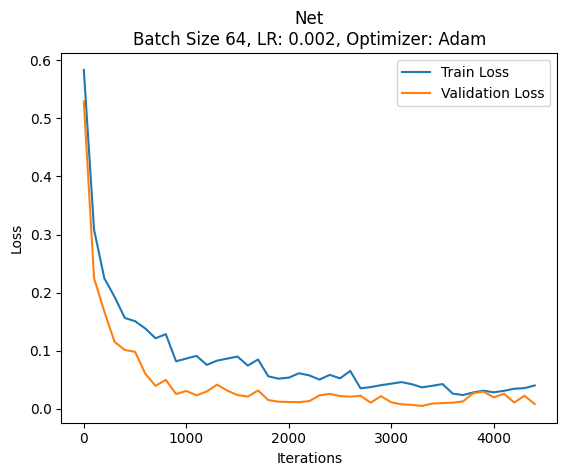

In [63]:
plot_learning_curve(Net_64_loss_avg_train, Net_64_loss_avg_valid, "Net\nBatch Size 64, LR: 0.002, Optimizer: Adam")

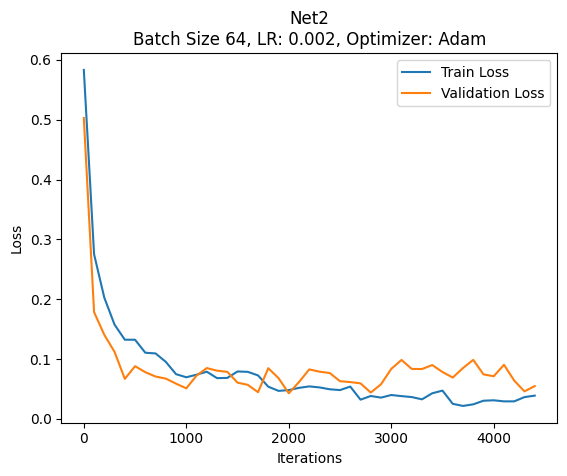

In [64]:
plot_learning_curve(Net2_64_loss_avg_train, Net2_64_loss_avg_valid, "Net2\nBatch Size 64, LR: 0.002, Optimizer: Adam")

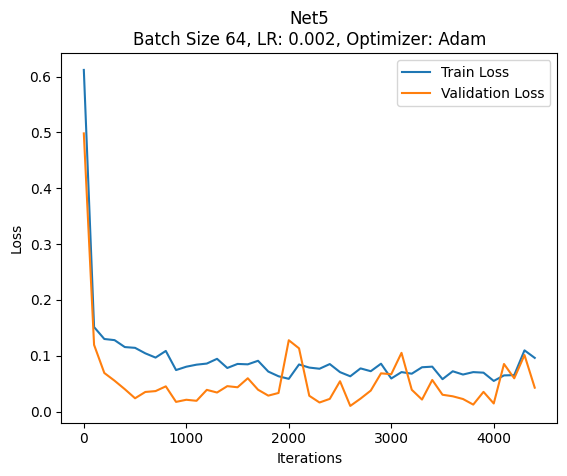

In [65]:
plot_learning_curve(Net5_64_loss_avg_train, Net5_64_loss_avg_valid, "Net5\nBatch Size 64, LR: 0.002, Optimizer: Adam")

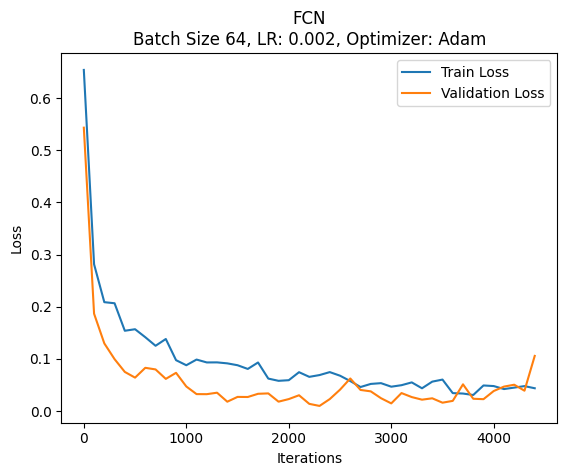

In [66]:
plot_learning_curve(FCN_64_loss_avg_train, FCN_64_loss_avg_valid, "FCN\nBatch Size 64, LR: 0.002, Optimizer: Adam")

#### 5-Layer CNN
Similar to the 2-Layer model, make a new class ```Net5```

* ***Layer 1 (Input)***: Convolutional, input channel = 1, output channel = 32, kernel size = 5, stride = 1, padding = 2.
* ***Layer 2 (Hidden 1)***: Pooling, kernel size = 2, stride = 2.
* ***Layer 3 (Hidden 2)***: Convolutional, input channel = < you find out> , output channel = 64, kernel size = 5, stride = 1 padding = 2.
* ***Layer 4 (Hidden 3)***: Fully connected, input channel = < you find out>, output channel = 1024.
* ***Layer 5 (Output)***: Fully connected, input channel = < you find out>, < you find out >

In [59]:
# YOUR CODE HERE (NET5)

# ...

# Define 5-Layer Network
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # After max pool, dimensions are 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2)
        self.relu = nn.ReLU() # No Max Pool, so we'll use ReLU to activate
        self.fc1 = nn.Linear(14*14 * 64,  1024) # Original image is 28x28, after max pool, dimensions are now 14x14
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# ...

#### FCN

Here we will define a Fully Connected Network `FCN` (Not a CNN).

- **Layer 1 (Input):** Size = < you find out >
- **Layer 2 (Hidden 1):** 256 neurons
- **Layer 3 (Hidden 2):** 256 neurons
- **Layer 4 (Output):** Size = < you find out >

In [60]:
# YOUR CODE HERE (FCN)

# ...

# Define FCN
class FCN(nn.Module):
    def __init__(self, input_size, num_classes):
      super(FCN, self).__init__()
      self.fc1 = nn.Linear(input_size, 256) # Input size should be 28x28, or 784
      self.relu1 = nn.ReLU()
      self.fc2 = nn.Linear(256, 256)
      self.relu2 = nn.ReLU()
      self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
      out = self.fc1(x)
      out = self.relu1(out)
      out = self.fc2(out)
      out = self.relu2(out)
      out = self.fc3(out)
      return out

# ...

In [67]:
# Learning Rate 2e-3, "FCN"
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 1-Layer Model
net = FCN(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
FCN_acc_arr_train, FCN_acc_arr_valid, FCN_loss_avg_train, FCN_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.1911, Val Loss: 0.2010
Epoch [1/5], Step [200/937], Train Loss: 0.1667, Val Loss: 0.1095
Epoch [1/5], Step [300/937], Train Loss: 0.1866, Val Loss: 0.1033
Epoch [1/5], Step [400/937], Train Loss: 0.1379, Val Loss: 0.0874
Epoch [1/5], Step [500/937], Train Loss: 0.1245, Val Loss: 0.0654
Epoch [1/5], Step [600/937], Train Loss: 0.1020, Val Loss: 0.0812
Epoch [1/5], Step [700/937], Train Loss: 0.0393, Val Loss: 0.0728
Epoch [1/5], Step [800/937], Train Loss: 0.0507, Val Loss: 0.0358
Epoch [1/5], Step [900/937], Train Loss: 0.1885, Val Loss: 0.0491
Epoch [1/5], Time Taken: 15.4000, Train Acc: 96.7767, Valid Acc: 96.4900
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.0244, Val Loss: 0.0204
Epoch [2/5], Step [200/937], Train Loss: 0.0178, Val Loss: 0.0310
Epoch [2/5], Step [300/937], Train Loss: 0.1698, Val Loss: 0.0320
Epoch [2/5], Step [400/937], Train Loss: 0.0787, Val Loss: 0.0337
Epoch 

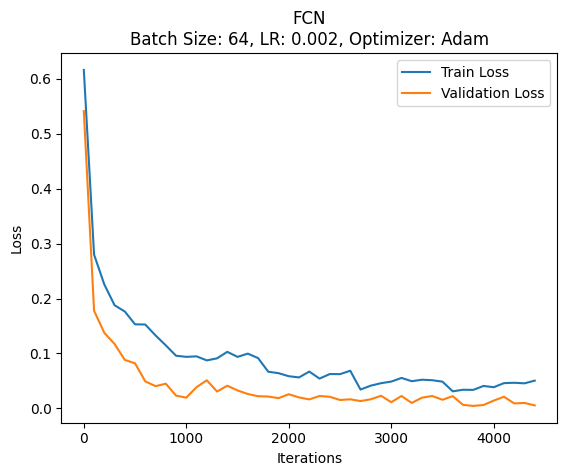

In [69]:
plot_learning_curve(FCN_loss_avg_train, FCN_loss_avg_valid, "FCN\nBatch Size: 64, LR: 0.002, Optimizer: Adam")



---



---



### 5.8) Batch Normalization

Choose the model that performs the best (`Net`, `Net2`, `Net5`, `FCN`). Add batch normalization layers where you see fit. Repeat and train and plot learning curves.

#### **Q 5.8) Explain the purpose of the batch normalization layers,and how they affect training.**



5.8 Batch Normalization layers are used to normalize the output of a layer in the neural network. These normalized inputs prevent the activations from getting to large or small, issues that can cause gradient vanishing in some cases. As a result of the normalized inputs, batch normilzation stabilizes and speeds up the training process.

In [76]:
# Net 2 performs the best.
class Net2_Batch_Layers(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_Batch_Layers, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.batch = nn.BatchNorm2d(20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.batch(out)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [77]:
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 2-Layer Model with batch normalization layers
net = Net2_Batch_Layers(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
batch_norm_acc_arr_train, batch_norm_acc_arr_valid, batch_norm_loss_avg_train, batch_norm_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.3736, Val Loss: 0.0983
Epoch [1/5], Step [200/937], Train Loss: 0.3374, Val Loss: 0.1441
Epoch [1/5], Step [300/937], Train Loss: 0.4222, Val Loss: 0.1259
Epoch [1/5], Step [400/937], Train Loss: 0.1700, Val Loss: 0.1052
Epoch [1/5], Step [500/937], Train Loss: 0.1131, Val Loss: 0.0910
Epoch [1/5], Step [600/937], Train Loss: 0.1786, Val Loss: 0.2335
Epoch [1/5], Step [700/937], Train Loss: 0.0469, Val Loss: 0.2018
Epoch [1/5], Step [800/937], Train Loss: 0.1047, Val Loss: 0.0993
Epoch [1/5], Step [900/937], Train Loss: 0.0637, Val Loss: 0.1814
Epoch [1/5], Time Taken: 15.8547, Train Acc: 98.1433, Valid Acc: 97.4700
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.0461, Val Loss: 0.0709
Epoch [2/5], Step [200/937], Train Loss: 0.0814, Val Loss: 0.1492
Epoch [2/5], Step [300/937], Train Loss: 0.0028, Val Loss: 0.1843
Epoch [2/5], Step [400/937], Train Loss: 0.0677, Val Loss: 0.0823
Epoch 

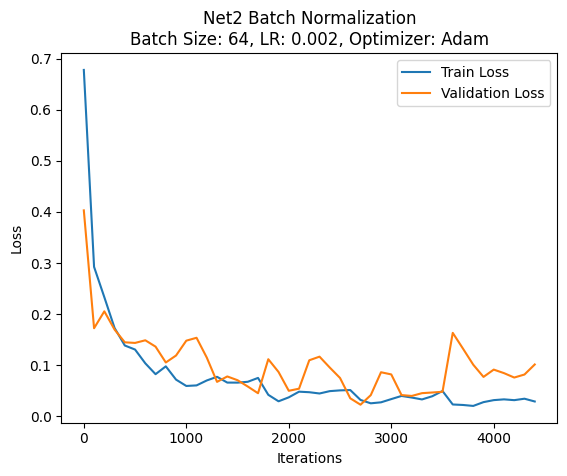

In [78]:
plot_learning_curve(batch_norm_loss_avg_train, batch_norm_loss_avg_valid, "Net2 Batch Normalization\nBatch Size: 64, LR: 0.002, Optimizer: Adam")

---